## Imports

In [110]:
# generic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm import tqdm
tqdm.pandas(desc="Progress Bar")

# text-preprocessing imports
import re
import nltk
import contractions # for expanding short-form texts
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# LSA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# text-visualizing
from sklearn.manifold import TSNE

from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

In [96]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

## # Problem Statement

* We have a lot of documents and those are from multi-domain and the documents nature are also different. Some might be showing comversation between 2 or more people, some might be giving factual information some might be abstrative in nature.

* The length of the documents are also varying in nature. Some might have 100 words while rest might have around 1000 words so one, document can be 10 times larger then the another document.

* ***To get an idea behind what in general a document is about, we will extract topics out of them. Each document can be respresented in n number of topics but will be only going with the top 3 topics or the top most topic a document might contain to get a gist of the document.***

## 1. Get the Data & Process it in desired format

The `article` field in each `txt` document in the RACE dataset is consolidated into a single `../input/documnets.csv` file for the topic modelling purpose.

In [1]:
%%time 

import os
import tarfile

if not os.path.isdir("../input/RACE"):
    tar =  tarfile.open("../input/RACE.tar.gz") 
    tar.extractall("../input/")
    tar.close()

CPU times: total: 15.2 s
Wall time: 17.7 s


In [1]:
import os
    
for dirpath, dirnames, filenames in os.walk("..\input\RACE"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")

There are 3 directories and 0 files in '..\input\RACE'
There are 2 directories and 0 files in '..\input\RACE\dev'
There are 0 directories and 1021 files in '..\input\RACE\dev\high'
There are 0 directories and 368 files in '..\input\RACE\dev\middle'
There are 2 directories and 0 files in '..\input\RACE\test'
There are 0 directories and 1045 files in '..\input\RACE\test\high'
There are 0 directories and 362 files in '..\input\RACE\test\middle'
There are 2 directories and 0 files in '..\input\RACE\train'
There are 0 directories and 18728 files in '..\input\RACE\train\high'
There are 0 directories and 6409 files in '..\input\RACE\train\middle'


In [30]:
%%time

import os
import csv
import json

data_path = "../input/RACE"

if not os.path.isfile("../input/documents.csv"):
    document_file = open("../input/documents.csv", mode="w", newline="")
    csv_writer = csv.writer(document_file)

    # Writing the header
    csv_writer.writerow(['document'])

    for folder in os.listdir(data_path)[::-1]:
        for sub_folder in os.listdir(os.path.join(data_path, folder)):
            for file in os.listdir(os.path.join(data_path, folder, sub_folder)):
                file_path = os.path.join(data_path, folder, sub_folder, file)

                with open(file_path, "r") as json_file:
                    json_data = json.load(json_file)

                # Writing the 'article' in 'document' column
                csv_writer.writerow([json_data['article']])

    document_file.close()

CPU times: total: 4.84 s
Wall time: 4.98 s


## 2. Data Loading & train-test split

In [2]:
df = pd.read_csv("../input/documents.csv")
df.shape

(27933, 1)

In [3]:
print(df.document[0])

My husband is a born shopper. He loves to look at things and to touch them. He likes to compare prices between the same items in different shops. He would never think of buying anything without looking around in several different shops. On the other hand, I'm not a shopper. I think shopping is boring and unpleasant. If I like something and I have enough money to take it, I buy it at once. I never look around for a good price or a better deal. Of course my husband and I never go shopping together. Doing shopping together would be too painful for both of us. When it comes to shopping, we go our different ways.
Sometimes I ask my son Jimmy to buy some food in the shop not far from our home. But he is always absent-minded. This was his story.
One day I said to him, " I hope you won't forget what I have told you to buy." " No," said Jimmy. "I won't forget. You want three oranges , six eggs and a pound of meat."
He went running down the street to the shop. As he ran, he said to himself over 

### 90-10 train-test split

In [4]:
train_documents = df[:int(0.9*len(df))]
test_documents = df[int(0.9*len(df)):]

print(f"train-set: {len(train_documents)}\ntest-set: {len(test_documents)}")

assert len(train_documents)+len(test_documents) == len(df)

train-set: 25139
test-set: 2794


';l'## 3. Data Preprocessing/Cleaning

Text Cleaning Steps:

1. lower case everything
2. expand all the short-form words
3. remove any special chars like punctuations, numbers, urls,'\n' chars, etc
4. tokenize
5. remove stop words
6. lemmatize and stich back the stentences

and there you have your processed text data

In [5]:
import re
import contractions

stop_word = stopwords.words('english')
le = WordNetLemmatizer()

def text_preprocessing(text:str) -> str:
    if pd.isnull(text):
        return text
    
    # lower-case everything
    text = text.lower()
    
    # expand all the short-form words
    text = contractions.fix(text)
    
    # remove any special chars
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b', '', text) # Remove phone numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove other non-alphanumeric characters 
    
    # tokenization
    word_tokens = word_tokenize(text)
    
    # remove stop-word and lemmatize
    tokens = [le.lemmatize(w) for w in word_tokens if w not in stop_word and len(w)>1] #  and len(w)>3
    
    cleaned_text = " ".join(tokens)
    return cleaned_text

**Credits: This regex pattern was written in collaboration with ChatGPT**

1. `r'http\S+|www\S+|https\S+'`:

    - `http` and `https`: Matches the literal strings "http" and "https".
    - `\S+`: Matches one or more non-whitespace characters.
    - `|`: Acts as an OR operator, allowing multiple patterns to be matched.
    - `www`: Matches the literal string "www".
    - `\S+`: Matches one or more non-whitespace characters.
    - `https`: Matches the literal string "https".
    
This regular expression is used to match and remove URLs from the text. It can handle URLs starting with "http", "https", or "www" followed by any non-whitespace characters.

2. `r'\S+@\S+'`:

    - `\S+`: Matches one or more non-whitespace characters.
    - `@`: Matches the literal "@" character.
    - `\S+`: Matches one or more non-whitespace characters.

This regular expression is used to match and remove email addresses from the text. It looks for strings that contain one or more non-whitespace characters followed by the "@" symbol, followed by one or more non-whitespace characters.


3. `r'\b\d{1,3}[-./]?\d{1,3}[-./]?\d{1,4}\b'` is used to match and remove phone numbers in the specified formats. Let's break down the regular expression:

    - `\b`: Matches a word boundary, ensuring that the phone number is not part of a larger word.
    - `\d{1,3}`: Matches one to three digits.
    - `[-./]?`: Matches an optional hyphen, period, or forward slash.
    - `\d{1,3}`: Matches one to three digits.
    - `[-./]?`: Matches an optional hyphen, period, or forward slash.
    - `\d{1,4}`: Matches one to four digits.
    - `\b`: Matches a word boundary, ensuring that the phone number is not part of a larger word.

This regular expression can handle phone numbers in the formats you provided, such as "1-800-933-8613", "613-562-5315", "281/465-0955", and "(202) 225-6827". It allows for variations in the placement of hyphens, periods, or forward slashes.

In [6]:
# train_documents['clean_document'] = train_documents['document'].progress_apply(lambda x: text_preprocessing(str(x)))

train_documents = train_documents.assign(clean_document =\
                                         train_documents['document'].progress_apply(lambda x: text_preprocessing(str(x))))

train_documents.head()

Progress Bar: 100%|█████████████████████████████████████████████████████████████| 25139/25139 [00:47<00:00, 526.23it/s]


,document,clean_document
0,My husband is a born shopper. He loves to look...,husband born shopper love look thing touch lik...
1,Tea drinking was common in China for nearly on...,tea drinking common china nearly one thousand ...
2,"Once upon a time, there was a scholar who want...",upon time scholar wanted gain knowledge day ev...
3,When newspapers and radio describe the damage ...,newspaper radio describe damage caused hurrica...
4,Below is a page adapted from About Wikipedia ...,page adapted wikipedia take full advantage wik...


In [7]:
# test_documents['clean_document'] = test_documents['document'].progress_apply(lambda x: text_preprocessing(str(x)))

test_documents = test_documents.assign(clean_document =\
                                       test_documents['document'].progress_apply(lambda x: text_preprocessing(str(x))))

Progress Bar: 100%|███████████████████████████████████████████████████████████████| 2794/2794 [00:05<00:00, 550.62it/s]


In [8]:
# Compare random cleaned text with the original one

print("**Original:**\n",train_documents.iloc[2708]['document'], '\n')
print("**Cleaned:**\n", train_documents.iloc[2708]['clean_document'])

**Original:**
 Get the Emergency World Radio FREE
The U.S. Department of Homeland Security advises that every American home have an emergency   radio.
Every home needs an emergency radio in the event of hurricanes, tornadoes, earthquakes, electric power outages and even terrorist attacks.
Be Prepared in Any Situation
This Dynamo Emergency World Band Radio picks up the full AM/FM spectrum   and worldwide shortwave bands.
Most importantly, the Dynamo Emergency World Band Radio includes:
Hand crank generator (in case batteries fail)
Emergency flashlight
Newsmax Magazine's Special Offer --- $20 Bonus  
Newsmax magazine wants every American family to have this emergency radio and will send it to you for FREE. Just pay our standard shipping and handling charge of $5.95.
When you order you FREE Dynamo Emergency World Band Radio, you'll also receive four free issues of Newsmax magazine---a $20 value --- yours FREE.
Newsmax magazine brings you stories the major media won't report. But even they

### Saving the cleaned text documents

In [14]:
train_documents.to_csv("../input/cleaned_train_documents.csv", index=False)
test_documents.to_csv("../input/cleaned_test_documents.csv", index=False)

## 4. EDA

In [2]:
train_documents = pd.read_csv("../input/cleaned_train_documents.csv")
test_documents = pd.read_csv("../input/cleaned_test_documents.csv")

train_documents.head()

,document,clean_document
0,My husband is a born shopper. He loves to look...,husband born shopper love look thing touch lik...
1,Tea drinking was common in China for nearly on...,tea drinking common china nearly one thousand ...
2,"Once upon a time, there was a scholar who want...",upon time scholar wanted gain knowledge day ev...
3,When newspapers and radio describe the damage ...,newspaper radio describe damage caused hurrica...
4,Below is a page adapted from About Wikipedia ...,page adapted wikipedia take full advantage wik...


### 4.1 Getting most common words in our text corpus

In [108]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(n_top_words:int, count_vectorizer:CountVectorizer, text_data:pd.Series):
    """
    Returns top_n words from a text document along with their counts as,
    (words, respective_counts) in tuple format.
    Params:
        n: int, top n words you want
        count_vec: sklearn.feature_extraction.text.CountVectorizer object
        text_data: text document you wanna pass in pandas series/dataframe format
                   like `text_data['document']`
    """
    # convert the text data into matrix representation
    vectorized_text = count_vectorizer.fit_transform(text_data.values)
    
    # calculate total count of each word across the whole text corpus
    word_counts = vectorized_text.sum(axis=0)
    
    # get the indices of the top n most frequent words
    word_indices = word_counts.argsort().tolist()[0] # converts 2D-matrix into flat 1D-list
    word_indices = word_indices[::-1][:n_top_words] 
    
    # retrieves the counts of those words corresponding to the word_indices
    word_values = word_counts[0, word_indices].tolist()[0]
    
    # get the corresponding words with most frequent occurance in the corpus
    words = count_vectorizer.get_feature_names_out()[word_indices]
    
    return words, word_values

**Explanation of the above code:**

**This explanation is generated in collaboration with ChatGPT**

- `vectorized_text = count_vectorizer.fit_transform(text_data.values)`

    This line uses the `fit_transform()` method of the `count_vectorizer` object to convert the text data into a matrix representation. It performs two operations: fitting the `count_vectorizer` on the text data to learn the vocabulary, and then transforming the text data into a matrix of token counts. The resulting `vectorized_text` matrix represents the vectorized version of the text documents.
    
* **

- `word_counts = vectorized_text.sum(axis=0)`

    This line calculates the sum of word counts along the columns (axis=0) of the `vectorized_text` matrix. It computes the total count of each word across all the text documents. The resulting word_counts variable is a 2D matrix with a shape of `(1, n_features)`, where `n_features` represents the number of unique words in the vocabulary.
 
* **

``` 
word_indices = word_counts.argsort().tolist()[0] # converts 2D-matrix into flat 1D-list
word_indices = word_indices[::-1][:n_top_words] 
```

Here, the `argsort()` function is used to obtain the indices that would sort the word_counts array in ascending order. By using `[::-1]`, the order is reversed, resulting in the indices of the most frequent words. The `[:n_top_words]` part selects the top `n_top_words` indices from the reversed sorted indices. The resulting `word_indices` variable contains the indices of the most frequent words in descending order.

* **

- `word_values = word_counts[0, word_indices].tolist()[0]`

    This line retrieves the counts of the words corresponding to the word_indices from the `word_counts` matrix. It uses indexing to extract the counts of the top words. The `tolist()` method is used to convert the resulting 2D matrix into a 1D list. The `[0]` index at the end is used to access the list of counts.
    
* **

- `words = count_vectorizer.get_feature_names_out()[word_indices]`

    This line uses the `get_feature_names_out()` method of the `count_vectorizer` object to retrieve the feature names (words) corresponding to the `word_indices`. It returns an array of words based on the indices. The resulting words variable contains the top words corresponding to the `word_indices`.

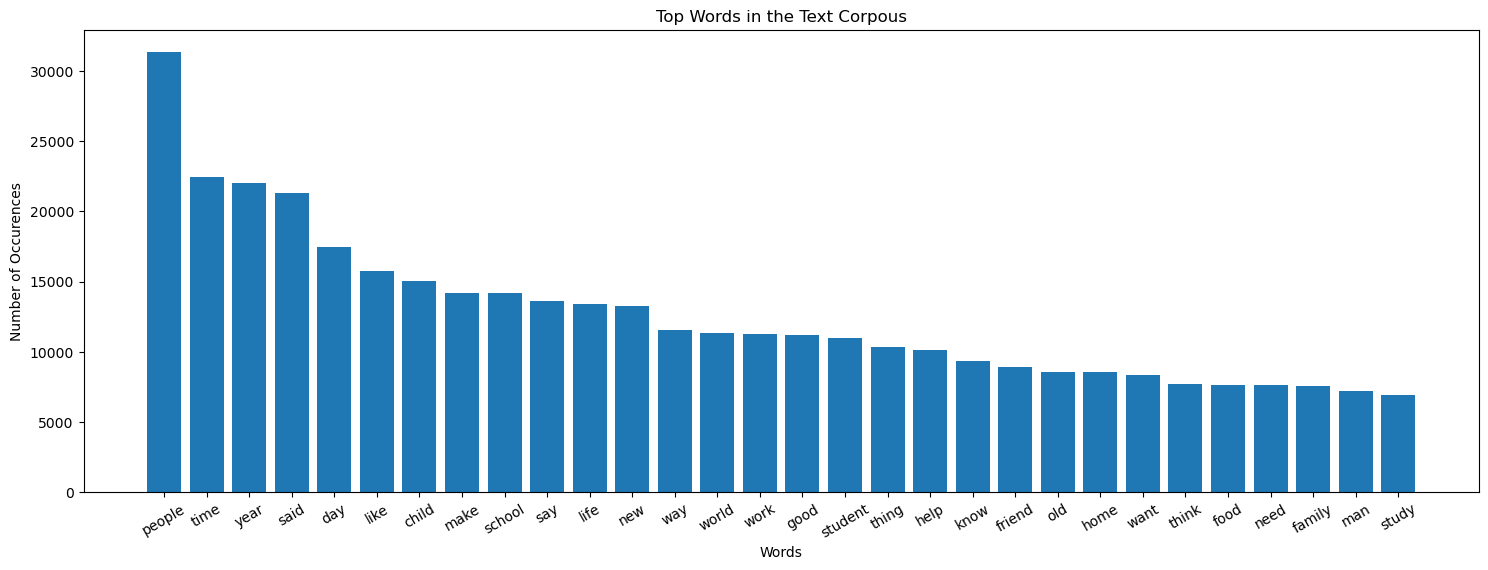

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")

top_n_words, word_counts = get_top_n_words(n_top_words=30, 
                                           count_vectorizer=cv,
                                           text_data=train_documents['clean_document'])

fig, ax = plt.subplots(figsize=(18,6))
ax.bar(range(1, len(top_n_words)+1), word_counts)
ax.set_xticks(range(1, len(top_n_words)+1))
ax.set_xticklabels(top_n_words, rotation=30)
ax.set_title("Top Words in the Text Corpous")
ax.set_xlabel("Words")
ax.set_ylabel("Number of Occurences")
plt.show();

### 4.2 Parts-of-Speech Tagging Analysis

In [107]:
from textblob import TextBlob

def stats_of_documents(data:pd.DataFrame):
    """
    Plots a BarPlot representing count of different Parts of Speech in the text corpus
    Params:
        data: pd.DataFrame, cleaned text dataframe
    """
    data = data['clean_document'].tolist()
    
    # PoS tagging
    tagged_documents = [TextBlob(data[i]).pos_tags for i in range(len(data))]
    tagged_documents_df = pd.DataFrame({'tags': tagged_documents})
    
    word_counts = []
    pos_counts = {}
    
    for tagged_text in tagged_documents_df['tags']:
        word_counts.append(len(tagged_text))
        
        for word, tag in tagged_text:
            if tag in pos_counts:
                pos_counts[tag] += 1
            else:
                pos_counts[tag] = 1
                
    print(f"Total number of words in the document: {np.sum(word_counts)}")
    print(f"Mean count of words per article in the document: {round(np.mean(word_counts))}")
    print(f"Minimum count of words of an article in the document: {np.min(word_counts)}")
    print(f"Maxmimum count of words of an article in the document: {np.max(word_counts)}")
    
    pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
    pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

    fig, ax = plt.subplots(figsize=(12,4))
    ax.bar(range(len(pos_counts)), pos_sorted_counts)
    ax.set_xticks(range(len(pos_counts)))
    ax.set_xticklabels(pos_sorted_types, rotation=30)
    ax.set_title('Part-of-Speech Tagging for the Corpus of Articles')
    ax.set_xlabel('Type of Word')
    plt.show();

Total number of words in the document: 3704585
Mean count of words per article in the document: 147
Minimum count of words of an article in the document: 1
Maxmimum count of words of an article in the document: 634


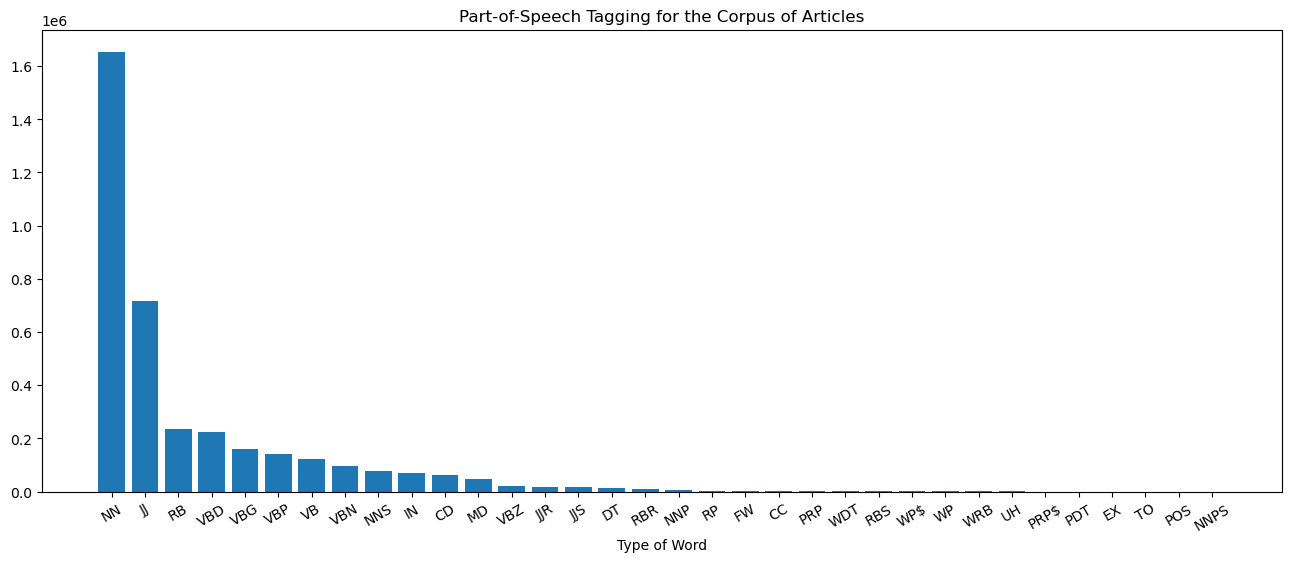

In [13]:
stats_of_documents(train_documents)

## 5. Topic Modelling

### 5.1 Latent Semantic Analysis(LSA)

LSA was unable to provide a greater degree of seperation as seen in t-SNE plot, almost all the documents belonged to a single topic, topic_0.LSA was unable to provide a greater degree of seperation as seen in t-SNE plot, almost all the documents belonged to a single topic, topic_0.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fitting using TfIdf, 4000 features are taken as the threshold so words having sufficient count will only be taken.
# As our vocabulary is not diverse, most words are from noun and more or less they are talking about 
# people, children, school etc etc...

vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=4000)

vect_text = vectorizer.fit_transform(train_documents['clean_document'])

In [16]:
from sklearn.decomposition import TruncatedSVD

# We will be going with the 10 topics as I tried with 15,20 topics but there was no improvement.
# n_iter is for 10 iterations with random_state as 42 to keep the results fixed

lsa_model = TruncatedSVD(n_components=10, algorithm='randomized',
                         n_iter=10, random_state=42)

lsa_top = lsa_model.fit_transform(vect_text)

In [35]:
lsa_top.shape, vect_text.shape

((25139, 10), (25139, 4000))

In [42]:
# Let's see the weightage of each topic in the first document

print("Document 0 :")
for i, topic in enumerate(lsa_top[0]):
    print(i, "-->" ,topic)

Document 0 :
0 --> 0.18433214962141295
1 --> -0.10041306072719966
2 --> 0.08315356414890353
3 --> -0.035955933474238755
4 --> 0.017866750202144094
5 --> -0.035613697800151146
6 --> 0.022349352036449784
7 --> -0.020416108029973862
8 --> -0.08344514399704583
9 --> -0.012983949858207722


In [43]:
def topics_document(model_output, n_topics , data):
    '''
    Returns a dataframe for each document having topic weightages
    and the dominant topic for each document.
    '''
    
    # column names
    topicnames = ["Topic_" + str(i) for i in range(n_topics)]
    
    # index names
    docnames = ["Doc_" + str(i) for i in range(len(data))]
    
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)
    
    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["dominant_topic"] = dominant_topic
    
    return df_document_topic

In [44]:
document_topic_lsa = topics_document(model_output=lsa_top, 
                                     n_topics=10, 
                                     data=train_documents)

document_topic_lsa

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,dominant_topic
Doc_0,0.18,-0.10,0.08,-0.04,0.02,-0.04,0.02,-0.02,-0.08,-0.01,0
Doc_1,0.13,-0.06,-0.03,-0.02,-0.00,-0.00,0.07,0.02,-0.08,-0.03,0
Doc_2,0.17,-0.03,-0.03,-0.02,0.02,-0.04,-0.01,-0.06,0.01,-0.01,0
Doc_3,0.10,-0.04,0.01,0.01,0.03,-0.00,-0.03,0.03,-0.02,-0.04,0
Doc_4,0.10,0.02,-0.07,-0.01,0.08,0.05,-0.02,-0.00,0.06,0.02,0
...,...,...,...,...,...,...,...,...,...,...,...
Doc_25134,0.12,-0.05,0.11,-0.02,0.04,-0.01,0.01,0.04,-0.03,0.03,0
Doc_25135,0.20,-0.07,-0.07,-0.11,-0.08,0.07,0.02,-0.20,-0.06,0.20,0
Doc_25136,0.23,0.12,0.02,-0.08,-0.04,-0.23,0.15,0.02,-0.08,-0.07,0
Doc_25137,0.21,-0.03,-0.03,0.02,0.04,-0.01,-0.06,0.02,0.00,-0.04,0


In [50]:
# In most of the documents topic_0 is dominant i.e most of the 
# documents is about topic_0
document_topic_lsa.dominant_topic.value_counts()

0    21706
1      712
3      403
6      392
8      388
2      384
4      382
9      381
5      258
7      133
Name: dominant_topic, dtype: int64

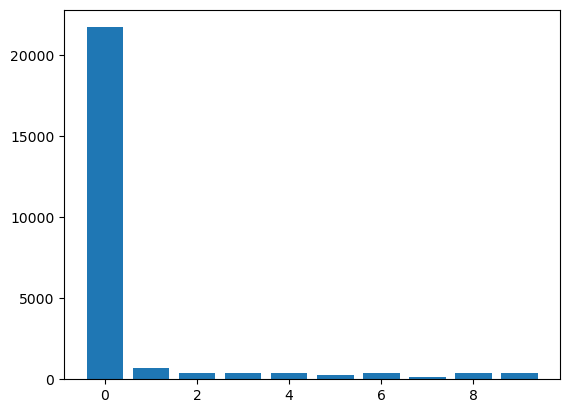

In [58]:
plt.bar(x = document_topic_lsa.dominant_topic.value_counts().index,
        height = document_topic_lsa.dominant_topic.value_counts().values);

* This plot is showing how the topics are not able to differentiate the words between them and the maximum documents almost more than 90% of the documents are assigned topic 0.

* Very few are documents are assigned other topics

In [79]:
vectorizer.get_feature_names_out()

array(['abandoned', 'ability', 'able', ..., 'zhang', 'zone', 'zoo'],
      dtype=object)

In [84]:
lsa_model.components_[0], lsa_model.components_[0].shape

(array([0.00227616, 0.02166587, 0.03353907, ..., 0.00774743, 0.00451889,
        0.00874563]),
 (4000,))

In [80]:
vectorizer.get_feature_names_out().shape, lsa_model.components_.shape

((4000,), (10, 4000))

* **Below we see what are the **top 10 words** for each documents, which gives us the idea what each topic is about.**


Here
```
Topic_0: 
people, school, child, said, time, year, student, day, like, life, 
```
In Topic_0, these are the most common words and 'people' has the most weightage in it.


So, based on the top_n words we can name a particular topic.

In [77]:
vocabulary = vectorizer.get_feature_names_out()

for i, component in enumerate(lsa_model.components_):
    vocab_comp = zip(vocabulary, component)
    
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    
    print("Topic_"+ str(i) + ": ")
    
    for t in sorted_words:
        print(t[0], end=", ")
        
    print("\n")

Topic_0: 
people, school, child, said, time, year, student, day, like, life, 

Topic_1: 
student, school, teacher, child, class, english, parent, education, college, language, 

Topic_2: 
mother, mr, father, man, boy, said, school, child, went, girl, 

Topic_3: 
child, parent, kid, family, life, feel, age, help, thing, make, 

Topic_4: 
english, language, book, word, friend, read, reading, people, learn, thing, 

Topic_5: 
child, chinese, china, english, book, language, city, year, world, country, 

Topic_6: 
food, english, eat, water, like, child, animal, chinese, school, language, 

Topic_7: 
english, language, woman, said, dog, food, chinese, study, man, animal, 

Topic_8: 
book, water, animal, dog, reading, read, plant, tree, story, scientist, 

Topic_9: 
car, english, child, language, mr, driver, road, bus, phone, driving, 



### 5.2.1 Visualizing topics with t-SNE

- [StatQuest: t-SNE, Clearly Explained](https://youtu.be/NEaUSP4YerM)
- [sklearn t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

* **t-Distributed Stochastic Neighbor Embedding (t-SNE)** is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

* The t-SNE algorithm reduces high-dimensional data into a lower-dimensional graph that retains a lot of the original information

- t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

    * KL is a statistical measure which is used to quantify how one distribution is different from another. Closer the value of **Kullback–Leibler(KL)** divergence to zero, the closeness of the corresponding words increases. In other words, the divergence value is less.

In [92]:
import numpy as np
from collections import Counter

# Define helper functions
def get_keys(topic_matrix):
    '''
    Returns an integer list of predicted topic categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


def get_mean_topic_vectors(keys, tSNE_vectors, n_topics):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(tSNE_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [91]:
colormap = np.array(["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
                     "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
                     "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
                     "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])

colormap = colormap[:10]

In [93]:
lsa_keys = get_keys(lsa_top)

lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [95]:
from sklearn.manifold import TSNE

tsne_lsa_model = TSNE(n_components=2, perplexity=50, 
                      learning_rate=100, n_iter=2000, angle=0.75,
                      verbose=0, random_state=0)

tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_top)

In [98]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors, n_topics=10)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(10), 
                 plot_width=700, plot_height=700)

plot.scatter(x = tsne_lsa_vectors[:,0], 
             y = tsne_lsa_vectors[:,1], 
             color = colormap[lsa_keys])

for t in range(10):
    label = Label(x = lsa_mean_topic_vectors[t][0], 
                  y = lsa_mean_topic_vectors[t][1], 
                  text_color = colormap[t])
    
    plot.add_layout(label)
    
show(plot)

* Evidently, this is a bit a of a failed result. We have failed to reach any great degree of separation across the topic categories, and it is difficult to tell whether this can be attributed to the LSA decomposition or instead the t -SNE dimensionality reduction process. Let's move forward and try another clustering technique.

* In Almost all the documents, the dominant topic comes out to be topic_0 which is having the top 10 keywords as :
    ```
    Topic_0: 
    people, school, child, said, time, year, student, day, like, life, 
    ```
    
* **

### 5.2.2 Generating Word-Clouds

The more bigger the word is, the more frequency/weightage having for the word is and the smaller word gets, the lesser frequency/weightage for that word is

In [101]:
from wordcloud import WordCloud

# Generate a word cloud image for given topic

vocabulary = vectorizer.get_feature_names_out()

def draw_word_cloud(topic_index, model):
    imp_words_topic=""
    
    component = model.components_[topic_index]
    
    vocab_comp = zip(vocabulary, component)
    
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]

    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

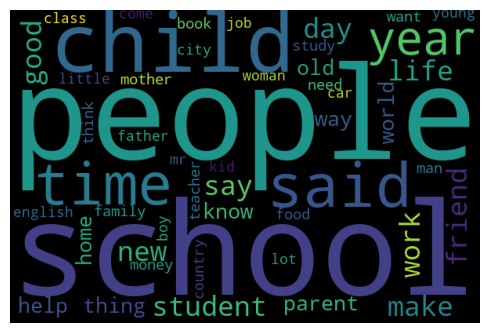

In [104]:
# Word Cloud for topic-0
draw_word_cloud(topic_index=0, model=lsa_model)

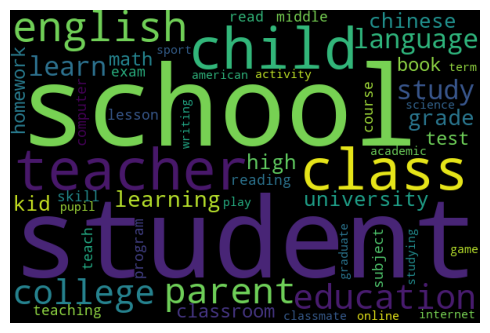

In [106]:
draw_word_cloud(1, lsa_model)

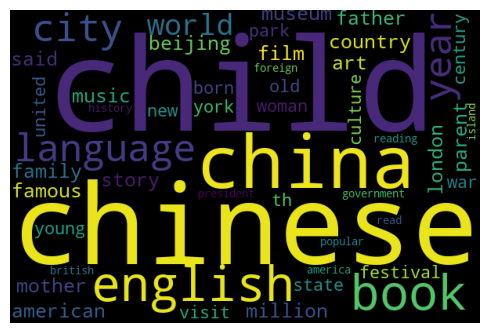

In [105]:
draw_word_cloud(5, lsa_model)

### 5.2.3 Predicting on test-documents

Total number of words in the document: 406228
Mean count of words per article in the document: 145
Minimum count of words of an article in the document: 8
Maxmimum count of words of an article in the document: 465


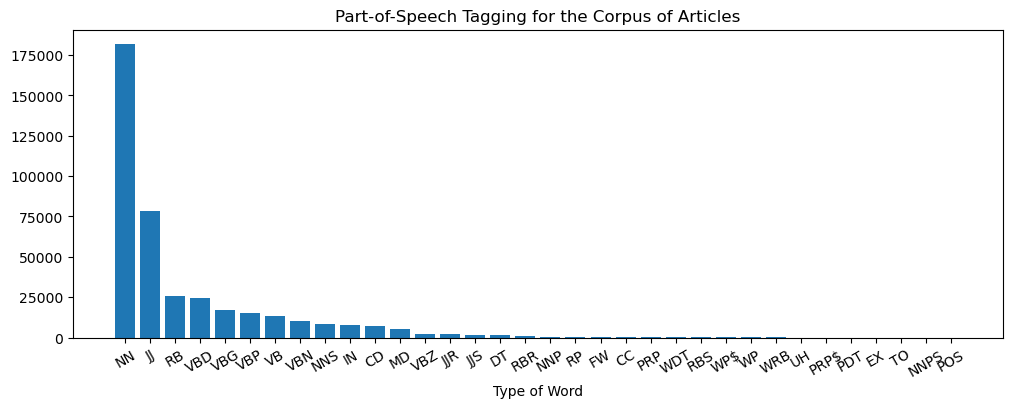

In [109]:
# Statistics for test-docs
stats_of_documents(test_documents)

In [111]:
vect_text_test = vectorizer.transform(test_documents['clean_document'])

lsa_top_test = lsa_model.transform(vect_text_test)

In [116]:
lsa_keys_test = get_keys(lsa_top_test)

lsa_categories_test, lsa_counts_test = keys_to_counts(lsa_keys_test)

lsa_categories_test, lsa_counts_test

([0, 1, 5, 8, 6, 3, 2, 9, 4, 7], [2376, 102, 33, 57, 54, 43, 45, 32, 40, 12])

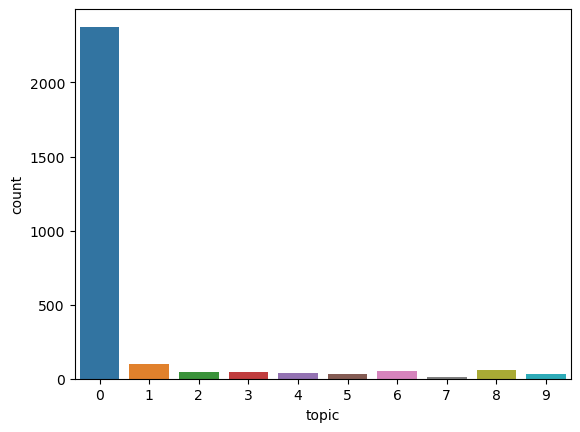

In [117]:
topics_df_test = pd.DataFrame({'topic' : lsa_categories_test, 'count' : lsa_counts_test})

sns.barplot(x=topics_df_test['topic'], y = topics_df_test['count'])

plt.show();

In [118]:
documet_topic_lsa_test = topics_document(model_output=lsa_top_test, 
                                         n_topics=10, 
                                         data=test_documents)
documet_topic_lsa_test

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,dominant_topic
Doc_0,0.14,-0.06,0.01,-0.01,0.02,0.00,0.01,-0.03,-0.05,-0.03,0
Doc_1,0.31,0.01,0.11,0.03,0.07,0.06,0.06,-0.11,0.27,-0.07,0
Doc_2,0.21,0.24,-0.09,-0.14,0.01,-0.04,-0.11,0.07,0.05,0.02,1
Doc_3,0.25,-0.05,0.03,0.05,0.13,-0.14,0.02,-0.03,-0.00,0.01,0
Doc_4,0.13,-0.04,-0.07,-0.04,-0.03,0.05,0.06,-0.07,-0.00,-0.03,0
...,...,...,...,...,...,...,...,...,...,...,...
Doc_2789,0.14,-0.03,0.06,0.07,-0.00,-0.03,0.14,0.04,-0.08,-0.01,0
Doc_2790,0.14,-0.06,0.05,-0.01,0.06,-0.01,0.01,-0.04,-0.02,-0.04,0
Doc_2791,0.08,-0.02,-0.02,0.00,-0.02,0.08,0.01,-0.10,0.02,0.04,0
Doc_2792,0.11,-0.09,0.07,-0.03,0.01,0.00,-0.07,0.10,-0.02,-0.02,0


### 5.3 Latent Dirichlet Allocation(LDA)

#### LDA - Articles

- https://towardsdatascience.com/latent-dirichlet-allocation-intuition-math-implementation-and-visualisation-63ccb616e094

- https://www.scaler.com/topics/nlp/topic-modelling-in-natural-language-processing/

- https://towardsdatascience.com/topic-modelling-f51e5ebfb40a

- https://levity.ai/blog/what-is-topic-modeling#:~:text=Topic%20modeling%20is%20a%20type,predefined%20tags%20or%20training%20data.

- https://www.analyticsvidhya.com/blog/2021/05/topic-modelling-in-natural-language-processing/

- https://monkeylearn.com/blog/introduction-to-topic-modeling/

- https://cbail.github.io/SICSS_Topic_Modeling.html

- https://www.geeksforgeeks.org/latent-dirichlet-allocation/https://www.geeksforgeeks.org/latent-dirichlet-allocation/

- https://www.youtube.com/watch?v=Cpt97BpI-t4


- https://www.analyticsvidhya.com/blog/author/chirag676/page/3/
- https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2021/06/part-16-step-by-step-guide-to-master-nlp-topic-modelling-using-lsa/